# 온라인 광고클릭 예측

- CTR: Click-Through Rate. 전체 페이지 뷰 횟수 대비 특정 광고를 클릭한 횟수의 비율
- 클릭 스루 예측이란 어떤 사용자가 현재 보고 있는 웹 페이지에 노출된 광고 클릭여부를 예측하는 이진 분류 문제
- 캐글 온라인 광고 클릭 예측모델을 위한 데이터 세트
- https://www.kaggle.com/c/avazu-ctr-prediction/downloadm/train.gz
- train.csv - 시간순으로 정렬된 10일간의 클릭 스루 예측을 위한 데이터

### 데이터 필드 구성
- id : 광고아이디
- click : 클릭하지 않은 경우 0, 클릭한 경우 1
- hour: YYMMDDHH 포맷
- C1 : 익명 처리된 범주형 변수
- banner_pos : 배너 위치 0,1
- site_id
- site_domain
- site_category
- app_id
- app_domain
- app_category
- dveic_id
- devic_ip
- device_model
- device_type
- device_conn_type
- C14-C21 -- 익명처리된 범주형 변수

> 범주형 데이터를 가지고 클릭으로 대상벡터(출력변수), 나머지를 입력변수로 사용하는 특징행렬 구성

In [2]:
import pandas as pd
import numpy as np

In [4]:
train_df = pd.read_csv('D:/Workspace/연습폴더/실습데이터_파이썬 머신러닝/train.csv', nrows=100000)

In [5]:
unused_columns, label_column = ['id', 'hour', 'device_id', 'device_ip'], 'click'
# 미사용 컬럼, 레이블 컬럼 구분

In [6]:
train_df = train_df.drop(unused_columns, axis=1)
# 미사용 컬럼 삭제

In [7]:
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values())
# 특징행렬 만들기, label을 없애고, df를 전치해 딕셔너리로 만들어 valeus만 추출

In [10]:
y_train = train_df[label_column]

In [11]:
test_df = pd.read_csv('D:/Workspace/연습폴더/실습데이터_파이썬 머신러닝/train.csv', 
                        header=0, skiprows=(1,100000), nrows=100000)
                        #헤더 첫번째 라인, 스킵 1부터 10만까지 train이므로 스킵하고 10만개를 가져옴

In [12]:
test_df = test_df.drop(unused_columns, axis=1)
# 미사용 컬럼 삭제

In [13]:
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())

In [14]:
y_test = test_df[label_column]

In [15]:
# 원 핫 인코딩 벡터 변환
from sklearn.feature_extraction import DictVectorizer
# 수치형은 트리기반 모델 가능하지만
# 범주형 데이터는 변환이 필요함

In [16]:
vectorize = DictVectorizer(sparse=True) #sparse=True 희소행렬로 만들어줌, 안하면 컴퓨터 꺼질수 있음(메모리에 문제)

In [17]:
X_train = vectorize.fit_transform(X_dict_train)

In [18]:
X_train.shape
# 19차원에서 4952 차원으로 늘어남

(100000, 4953)

In [19]:
X_train.toarray()[:5] #spars 매트릭스임

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

In [20]:
X_test = vectorize.fit_transform(X_dict_test)

In [21]:
X_test.shape

(100000, 4953)

In [22]:
## 그리드 서치를 이용한 의사결정 트리 모델 학습
from sklearn.tree import DecisionTreeClassifier

In [26]:
parameters = {'max_depth' : [3, 10, None]}
# 임의의값으로 max_depth를 잡음

In [24]:
decison_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)

In [25]:
from sklearn.model_selection import GridSearchCV

In [27]:
grid_search = GridSearchCV(decison_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
# n_jobs:-1 모든프로세스 사용, cv= 교차검증 3, scoring= 만들려는점수 분류평가 roc_auc: 분류평가 지포중하나로 곡선화 면적

In [28]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=30),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

In [29]:
grid_search.best_params_

{'max_depth': 3}

In [30]:
decison_tree_best = grid_search.best_estimator_

In [31]:
# 의사결정 트리 모델의 파일 출력
from sklearn.tree import export_graphviz

In [ ]:
export_graphviz(decison_tree_best, out_file='ctr_decision_tree.dot', feature_names=vectorizer.feature_names_,
                class_names=['0', '1'], rounded=True, filled=True, impurity = True)

In [34]:
import pydot

In [ ]:
graph = pydot.graph_from_dot_file('ctr_decison_tree.dot')[0]

In [ ]:
graph.write_png('ctr_decision_tree.png')

## 분류 모델의 성능 측정 방법
### 혼동 행렬

- 실제 관측값을 얼마나 정확하게 예측했는지 보여주는 행렬
- True Positive : 참-긍정; 예측: 참, 실제: 참 일치
- True negative : 참-부정; 예측: 참, 실제: 참 일치
- False Positive : 거짓-긍정; 예측:거짓, 실제 : 참 불일치 
- False negative : 거짓-부정; 예측:거짓, 실제 : 참 불일치
<br><br>
- 정확도 : accuracy. 전체 샘플에서 정확하게 예측한 샘플 수의 비율
- 정밀도 : precision. Positive 클래스로 예측한 샘플에서 실제 Positive클래스에 속하는 샘플
- 재현율 : recall. 실제 Positive클래스에 속한 샘플 Positive 클래스에 속한다고 예측한 샘플 수의 비율
- 위양성율 : fallout. 실제 Positve클래스에 속하지 않는 샘플에서 Positive클래스에 속한다고 예측한 샘플 수의 비율
<br> 거짓 긍정률: FalsePostiveRate
- F1 점수: f1 score. 정밀도와 재현율의 조화평균. 점수에 상수2를 곱해 정밀도와 재현율이 모두 1일 경우 점수가 1이 되도록 만듬
- 특이성 : specificity. 실제 Negative 클래스에 속한 샘플에서 Negative클래스에 속한다고 예측한 샘플 수의 비율(1-FPR)
- AUC: area under the curve. 곡선하 면적
- 참 긍정률TPR과 거짓 부정률FPR사이를 표현하기 위해 ROC커브를 사용
- 예측된 확률로 부터 여러 클래스로 분류를 수행하는 데 활용
> ROC 커브가 만들어지도록 모델 개선해야 함

In [48]:
# 의사결정 트리 모델의 성능측정 : 정확도, 혼동행렬,ROC의 AUC
y_pred = decison_tree_best.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [49]:
np.unique(y_pred, return_counts=True)
# 0: 클릭안함> 94507, 1:클릭함>5493 

(array([0, 1], dtype=int64), array([94507,  5493], dtype=int64))

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(y_test, y_pred)
# 맞춘값 82%

0.82655

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
confusion_matrix(y_test, y_pred)

array([[79836,  2674],
       [14671,  2819]], dtype=int64)

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve

In [61]:
y_pred_proba = decison_tree_best.predict_proba(X_test)[:, 1]
# predict_proba 분류의 확률, 1 = 클릭할 확률 정보
y_pred_proba

array([0.19983485, 0.19983485, 0.19983485, ..., 0.19983485, 0.09315951,
       0.09315951])

In [62]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#fpr, tpr 로 시각화 가능

In [63]:
auc = roc_auc_score(y_test, y_pred_proba)

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

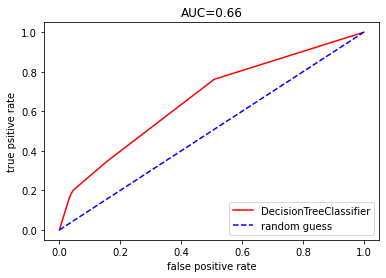

In [66]:
plt.plot(fpr, tpr, "r-", label='DecisionTreeClassifier')
        #x, y, color, 범례
plt.plot([0,1], [0,1], "b--", label='random guess')
        #x, y 의 점선
plt.xlabel("false positive rate")
plt.ylabel("true psitive rate")
plt.title("AUC={0:.2f}".format(auc))
plt.legend(loc='lower right');

## 앙상블 학습과 배깅

- 디시젼 트리의 가장큰 문제는 훈련데이터에 대한 고분산성을 갖음
- 앙상블은 성능이 좋지 않은 알고리즘들을 결합시켜 종합한 결과 더 좋게 만드는 것(대표 케이스 배깅)
- 부트스트랩: Bootstrap. 중복을 허용하는 리샘플링
- 배깅 : Bagging. Bottstrap aggregating의 약자
    - 훈련 데이터에서 부트스트래핑한 샘플에 대해 모든 변수를 선택해 다수의 의사결정 트리를 구성
    <br>(의사결정 트리의 분할을 위해 선택된 변수가 모든 트리에서 대체로 비슷해져 상관관계를 가지고 종합을 해도 분산 감소효과가 기대만큼 크지 않을 수 있음)
    - 하나의 예측기를 위해 같은 훈련 샘플을 여러번 샘플링 할 수 있음
    - 동시에 CPU의 멀티코어나 병렬 프로세서에서 학습을 진행하는 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 만듬
    - 개별 예측기의 편향은 높지만, 수집함수를 통과한 후 앙상블의 결과는 원본 데이터 셋으로 하나의 예측기를 훈련시킬 때보다 편향은 비슷하지만 대체로 분산은 줄어듬


## 랜덤포레스트
- 랜덤 포레스트는 특징 기반 배깅 방법을 적용한 의사결정 트리의 앙상블
> 특징기반 배깅 : 특징을 선택적, 무작위적으로 사용함
- 트리 배깅은 의사결정 트리 모델의 단점 중 하나인 고분산을 줄여주며 이를 통해 단일 트리보다 훨씬 더 좋은 성능을 제공함
- 개별 트리간의 상관관계 문제를 피하기 위해 부트스트래핑 과정에서 훈련 데이터로부터 전체 p개의 변수중 m개의 변수만 선택
- 랜덤 포레스트의 무작위성 주입은 트리를 보다 다양하게 만들고, 편향을 손해 보는 대신, 분산을 낮추어 훌륭한 모델을 만듬
<br><br>
### 특징 중요도
- 의사결정 트리를 기반으로 하는 모델이므로 특징의 상대적 중요도를 측정하기 쉬운 장점
- 무작위성이 주입된 랜덤포레스트 모델은 의사결정 트리와 달리 모든 특징에 대해 중요도를 측정함
- 랜덤포레스트의 특징 중요도는 각 의사결정 트리의 특징 중요도를 모두 합한 후 트리의 수로 나눈것으로, Scikit-Learn의 경우 중요도의 합이 1이 되도록 결과값을 졍규화 함


In [67]:
# 온라인 광고 클릭 예측을 위한 모델 개선

from sklearn.datasets import load_iris
iris = load_iris()

In [68]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1)
                                    # n_estimators=500, n_jobs=-1 전체 데이터 다사용
random_forest.fit(iris.data, iris.target)
# iris.data, iris.target 전체 데이터 다 사용

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [70]:
for feture, importance in zip(iris.feature_names, random_forest.feature_importances_):
    # 배제된것 없이 모두 중요도 확인
    print(f'{feture}, {importance}')

sepal length (cm), 0.0955109779418728
sepal width (cm), 0.02229323472880532
petal length (cm), 0.4233681027236561
petal width (cm), 0.45882768460566575


In [72]:
# 특징 기반 배깅을 이용하는 트리 배깅 모델 랜덤 포레스트의 학습
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)

In [73]:
grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

In [74]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(min_samples_split=30, n_jobs=-1),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

## 랜덤 포레스트의 성능 개선을 위한 주요 파라미터(=하이퍼파라미터 : 우리가 지정해서 써야함)
- max_features : 최적의 분할 지점을 찾기 위해 검토할 특징의 개수. 일반적으로 n차원의 데이터세트의 루트n의 반올림 값을 설정
- n_estimator : 트리의 개수가 많을 수록 성능이 좋지만 계산시간이 많이 걸림. 일반적으로 100, 200, 500을 설정(500이상은 차이가 거의 없음)
- min_sample_splits : 노드에서 추가 분할을 위해 필요한 샘플의 최소 개수. 숫자가 너무 작으면 오버피팅, 너무 크면 언더피팅, 일반적으로 10, 30, 50 으로 시작

In [75]:
# 랜덤포레스트 모델의 성능 측정 : 정확도, 혼동행렬, ROC의 AUC

grid_search.best_params_

{'max_depth': 10}

In [76]:
random_forest_best = grid_search.best_estimator_

In [78]:
y_pred = random_forest_best.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [79]:
accuracy_score(y_test, y_pred)

0.8251

In [80]:
confusion_matrix(y_test, y_pred)

array([[82510,     0],
       [17490,     0]], dtype=int64)

In [81]:
y_pred_proba = random_forest_best.predict_proba(X_test)[: , 1]
y_pred_proba

array([0.19796831, 0.18762147, 0.19862588, ..., 0.18674314, 0.11940334,
       0.12102011])

In [82]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [83]:
auc = roc_auc_score(y_test, y_pred_proba)

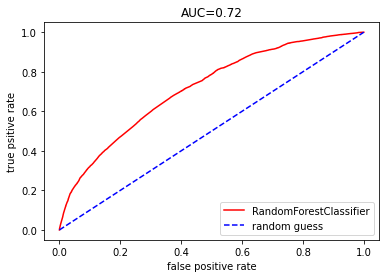

In [84]:
plt.plot(fpr, tpr, "r-", label='RandomForestClassifier')
        #x, y, color, 범례
plt.plot([0,1], [0,1], "b--", label='random guess')
        #x, y 의 점선
plt.xlabel("false positive rate")
plt.ylabel("true psitive rate")
plt.title("AUC={0:.2f}".format(auc))
plt.legend(loc='lower right');

In [85]:
# randomclassfier는 디시젼 트리보다 분명히 더 좋은 성능들을 제공해 주는 강점이 있음